In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import joblib  # For saving the scalers
from sklearn.metrics import mean_absolute_error, r2_score, roc_auc_score
import matplotlib.pyplot as plt

In [39]:
# Load datasets
train_df = pd.read_csv('train_data/train_data.csv')
test_df = pd.read_csv('train_data/test_data.csv')

print(f"Train rows: {len(train_df)} | Test rows: {len(test_df)}")
print(f"Unique Sessions in Train: {train_df['session_id'].nunique()}")

Train rows: 55870 | Test rows: 13777
Unique Sessions in Train: 96


In [40]:
train_df.head(5)

,size,delay,bif,iat_mean,iat_std,throughput_mbps,delay_gradient,bif_gradient,is_silent,session_id,target_next_throughput
0,128,47.882000,0.0,47.882000,0.000000,0.02048,0.000000,0.0,0,0,0.4992
1,3120,47.693250,0.0,11.928500,23.773011,0.49920,-0.188750,0.0,0,0,0.0000
2,0,0.000000,0.0,0.000000,0.000000,0.00000,-47.693250,0.0,1,0,48.1728
3,301080,47.365360,60840.0,0.117759,1.878513,48.17280,47.365360,60840.0,0,0,9.7344
4,60840,47.151641,70200.0,0.022769,0.022967,9.73440,-0.213719,9360.0,0,0,47.9232


In [41]:
test_df.head(5)

,size,delay,bif,iat_mean,iat_std,throughput_mbps,delay_gradient,bif_gradient,is_silent,session_id,target_next_throughput
0,96,50.640000,0.0,50.640000,0.000000,0.01536,0.000000,0.0,0,0,0.00000
1,0,0.000000,0.0,0.000000,0.000000,0.00000,-50.640000,0.0,1,0,0.03712
2,232,50.526000,0.0,50.526000,0.000000,0.03712,50.526000,0.0,0,0,0.00000
3,0,0.000000,0.0,0.000000,0.000000,0.00000,-50.526000,0.0,1,0,0.45568
4,2848,50.619667,32868.0,1.705333,2.456684,0.45568,50.619667,32868.0,0,0,5.69920


In [42]:
# Define features and target
# We exclude 'ts' and 'session_id' from features
features = ['size', 'delay', 'bif', 'iat_mean', 'iat_std', 
            'throughput_mbps', 'delay_gradient', 'bif_gradient', 'is_silent']
target = 'target_next_throughput'

### Scaling

In [43]:
scaler = RobustScaler()

# Fit on training features only
train_df[features] = scaler.fit_transform(train_df[features])

# Transform testing features using training parameters
test_df[features] = scaler.transform(test_df[features])

print("Scaling complete. Data is now centered around the median with reduced outlier impact.")

Scaling complete. Data is now centered around the median with reduced outlier impact.


In [44]:
# Save Scalers (CRITICAL for live Tshark use later)
joblib.dump(scaler, 'model_files/scaler_x.pkl')

['model_files/scaler_x.pkl']

### Session-Aware Sequence Building

In [45]:
def create_session_sequences(df, feature_cols, target_col, window_size):
    X, y = [], []
    
    # Process each session independently to avoid "data bleeding"
    for session_id, group in df.groupby('session_id'):
        data = group[feature_cols].values
        labels = group[target_col].values
        
        if len(data) < window_size:
            continue
            
        for i in range(len(data) - window_size):
            X.append(data[i : i + window_size])
            y.append(labels[i + window_size])
            
    return np.array(X), np.array(y)

WINDOW_SIZE = 15 # 15 windows * 50ms = 7500ms look-back

X_train, y_train = create_session_sequences(train_df, features, target, WINDOW_SIZE)
X_test, y_test = create_session_sequences(test_df, features, target, WINDOW_SIZE)

# Convert to PyTorch Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

### Defining the LSTM Architecture

In [46]:
class TrafficLSTM(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128, num_layers=2):
        super(TrafficLSTM, self).__init__()
        # Increased hidden_dim to 128 to capture more complex patterns
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 128).to(x.device)
        c0 = torch.zeros(2, x.size(0), 128).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

In [47]:
model = TrafficLSTM()
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

### Training Loop

In [48]:
train_loader = DataLoader(list(zip(X_train_t, y_train_t)), batch_size=64, shuffle=True)

epochs = 20
for epoch in range(epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

Epoch 1/20, Loss: 125.087616
Epoch 2/20, Loss: 71.667061
Epoch 3/20, Loss: 56.743027
Epoch 4/20, Loss: 76.356621
Epoch 5/20, Loss: 53.392197
Epoch 6/20, Loss: 67.313805
Epoch 7/20, Loss: 38.424797
Epoch 8/20, Loss: 43.411613
Epoch 9/20, Loss: 46.135563
Epoch 10/20, Loss: 39.160023
Epoch 11/20, Loss: 34.074356
Epoch 12/20, Loss: 49.302437
Epoch 13/20, Loss: 54.998726
Epoch 14/20, Loss: 40.104935
Epoch 15/20, Loss: 68.783188
Epoch 16/20, Loss: 22.163094
Epoch 17/20, Loss: 49.678890
Epoch 18/20, Loss: 67.257004
Epoch 19/20, Loss: 32.293354
Epoch 20/20, Loss: 59.473629


In [49]:
# Save the weights
torch.save(model.state_dict(), 'model_files/tcp_forecast_model.pth')

# Save Entire Model
torch.save(model, 'model_files/model_architecture.pt')

### Model Evaluation

In [50]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_t)
    test_loss = criterion(predictions, y_test_t)

    y_pred_rescaled = predictions.numpy().flatten()
    y_test_rescaled = y_test_t.numpy().flatten()
    
# Convert back to original scale (optional, but useful for Mbps visualization)
# Since we predicted throughput_mbps, we can compare directly
print(f"Test Huber Loss: {test_loss.item():.4f}")

# Sample Comparison
for i in range(5):
    print(f"Actual: {y_test[i]:.2f} Mbps | Predicted: {predictions[i].item():.2f} Mbps")

Test Huber Loss: 68.7053
Actual: 421.87 Mbps | Predicted: 287.60 Mbps
Actual: 555.60 Mbps | Predicted: 526.02 Mbps
Actual: 746.02 Mbps | Predicted: 658.76 Mbps
Actual: 734.00 Mbps | Predicted: 698.20 Mbps
Actual: 785.08 Mbps | Predicted: 750.19 Mbps


In [51]:
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"MAE: {mae:.2f} Mbps")
print(f"R2 Score: {r2:.2f}")

MAE: 69.17 Mbps
R2 Score: 0.92


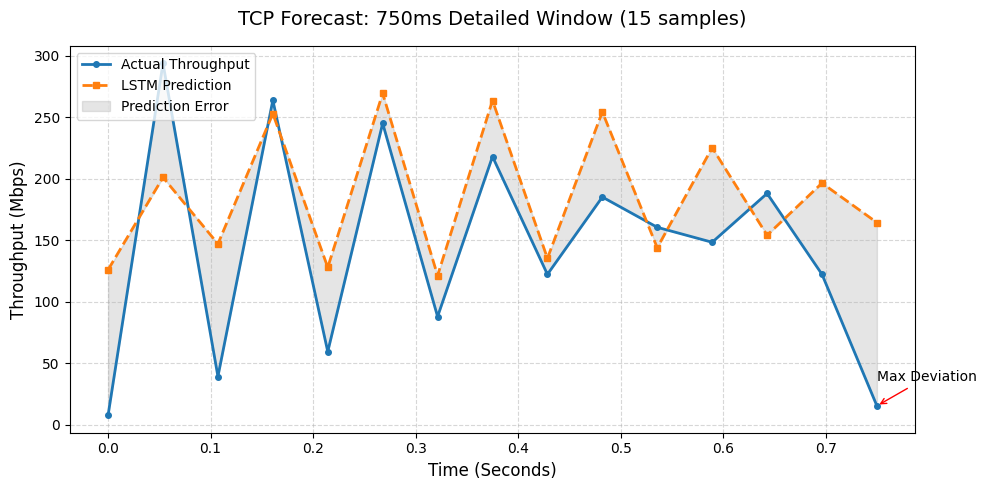

In [52]:
# --- DYNAMIC CONFIGURATION ---
MS_PER_POINT = 50 
LOOKBACK_MS = 750
# Calculate how many points represent 750ms
num_points = LOOKBACK_MS // MS_PER_POINT

# Slice the last 15 points
actual = y_test_rescaled[-num_points:]
predicted = y_pred_rescaled[-num_points:]

# Generate the time axis in seconds (0 to 0.75s)
time_axis = np.linspace(0, LOOKBACK_MS / 1000, num_points)

plt.figure(figsize=(10, 5), dpi=100)

# Plotting Lines
plt.plot(time_axis, actual, label='Actual Throughput', 
         color='#1f77b4', marker='o', markersize=4, linewidth=2)
plt.plot(time_axis, predicted, label='LSTM Prediction', 
         color='#ff7f0e', linestyle='--', marker='s', markersize=4, linewidth=2)

# Shaded Error Area
# This visually represents the "Loss" at every point in time
plt.fill_between(time_axis, actual, predicted, color='gray', alpha=0.2, label='Prediction Error')

# Adding descriptive labels and title
plt.title(f"TCP Forecast: 750ms Detailed Window ({num_points} samples)", fontsize=14, pad=15)
plt.xlabel("Time (Seconds)", fontsize=12)
plt.ylabel("Throughput (Mbps)", fontsize=12)

# Customizing the visual layout
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', frameon=True)

# Dynamic Annotation
# We point to the largest gap in this 750ms window
error = np.abs(actual - predicted)
max_err_idx = np.argmax(error)
plt.annotate('Max Deviation', 
             xy=(time_axis[max_err_idx], actual[max_err_idx]), 
             xytext=(time_axis[max_err_idx], actual[max_err_idx] + 20),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='red'))

plt.tight_layout()
plt.show()

In [56]:
# AUC for 'Congestion Event' Detection
# We define a crash as throughput dropping below 20 Mbps
threshold = 50
actual_crash = (y_test_rescaled < threshold).astype(int)
predicted_crash = (y_pred_rescaled < threshold).astype(int)
auc = roc_auc_score(actual_crash, predicted_crash)

In [57]:
print(f"Average Prediction Error: {mae:.2f} Mbps")
print(f"R-Squared (Variance Explained): {r2:.4f}")
print(f"Congestion Warning AUC: {auc:.4f}")

Average Prediction Error: 69.17 Mbps
R-Squared (Variance Explained): 0.9192
Congestion Warning AUC: 0.9794


In [58]:
print(f"Congestion Warning AUC: {auc:.4f}")

Congestion Warning AUC: 0.9794
